In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl

import bliss
import bliss.models.galaxy_net
import bliss.datasets.galsim_galaxies

In [2]:
%matplotlib inline

In [9]:
from hydra.experimental import initialize, compose
def get_cfg(overrides):
    """Function to obtain a configuration object that is used to create datasets and models."""
    overrides = [f"{key}={value}" for key, value in overrides.items()]
    with initialize(config_path="../../config"):
        cfg = compose("config", overrides=overrides)
    return cfg


def plot_example_galaxies(ds, n_samples=16):
    """Utility function to plot example images from a given galaxy dataset `ds`."""
    ax_slen = int(np.sqrt(n_samples))
    fig, axes = plt.subplots(ax_slen, ax_slen, figsize=(20, 20))

    for ax in axes.flatten():
        idx = np.random.randint(len(ds))
        ex = ds[idx]
        im = ax.imshow(ex['images'][0])
        fig.colorbar(im, ax=ax)

    plt.tight_layout()

# Gaussian Galaxies

First we create the configuration object for training the _'simple'_ VAE on a Gaussian dataset. 

In [21]:
overrides = {
             # dataset information
             'dataset':'toy_gaussian',
             'dataset.params.slen': 51,
             'dataset.batch_size': 128,
    
             # model info. 
             'model':'galaxy_net',
             'model.loss_type': 'L2', # another option is 'L1' for l1-loss. 
             'model.enc_dec_name': 'simple', # this specifies which architecture to use for the encoder/decoder. 
                                            # default is 'simple', the original VAE we were using. 
                                            # Other options are 'bastien' and 'jeff'. See bliss/models/vae_layers.py for options.
             'model.params.slen': 51,
    
             # pytorch lightning trainer. 
             'training': 'default'
}

Several architectures are now supported, see `bliss/models/vae_layers.py` for their implementation. You can select which architecture to use by changing `model.enc_dec_name` in the above `overrides` dictionary.

   * __simple__: Uses the standard VAE we were using before with 16 channels throughout. Uses `BatchNorm1d` and `Dropout`. Requires **odd** `slen` (see above).
   
   * __jeff__: Uses an approach where image `slen` is divided by 1/2 each time in consecutive layers. Keeps # of channels constant = 16. Requires `slen` which is $2^{i}$ where $i\geq4$
   
   * __bastien__: Uses the architecture in https://arxiv.org/abs/2005.12039. Requires `slen` which is $2^{i}$ where $i\geq4$
   
   
**NOTE:** The overall VAE is the same in all cases, the only thing that changes is the neural network architecture used to obtain encodings and decodings. 

In [22]:
cfg = get_cfg(overrides)
ds = bliss.datasets.galsim_galaxies.ToyGaussian(cfg)

## Examples from dataset

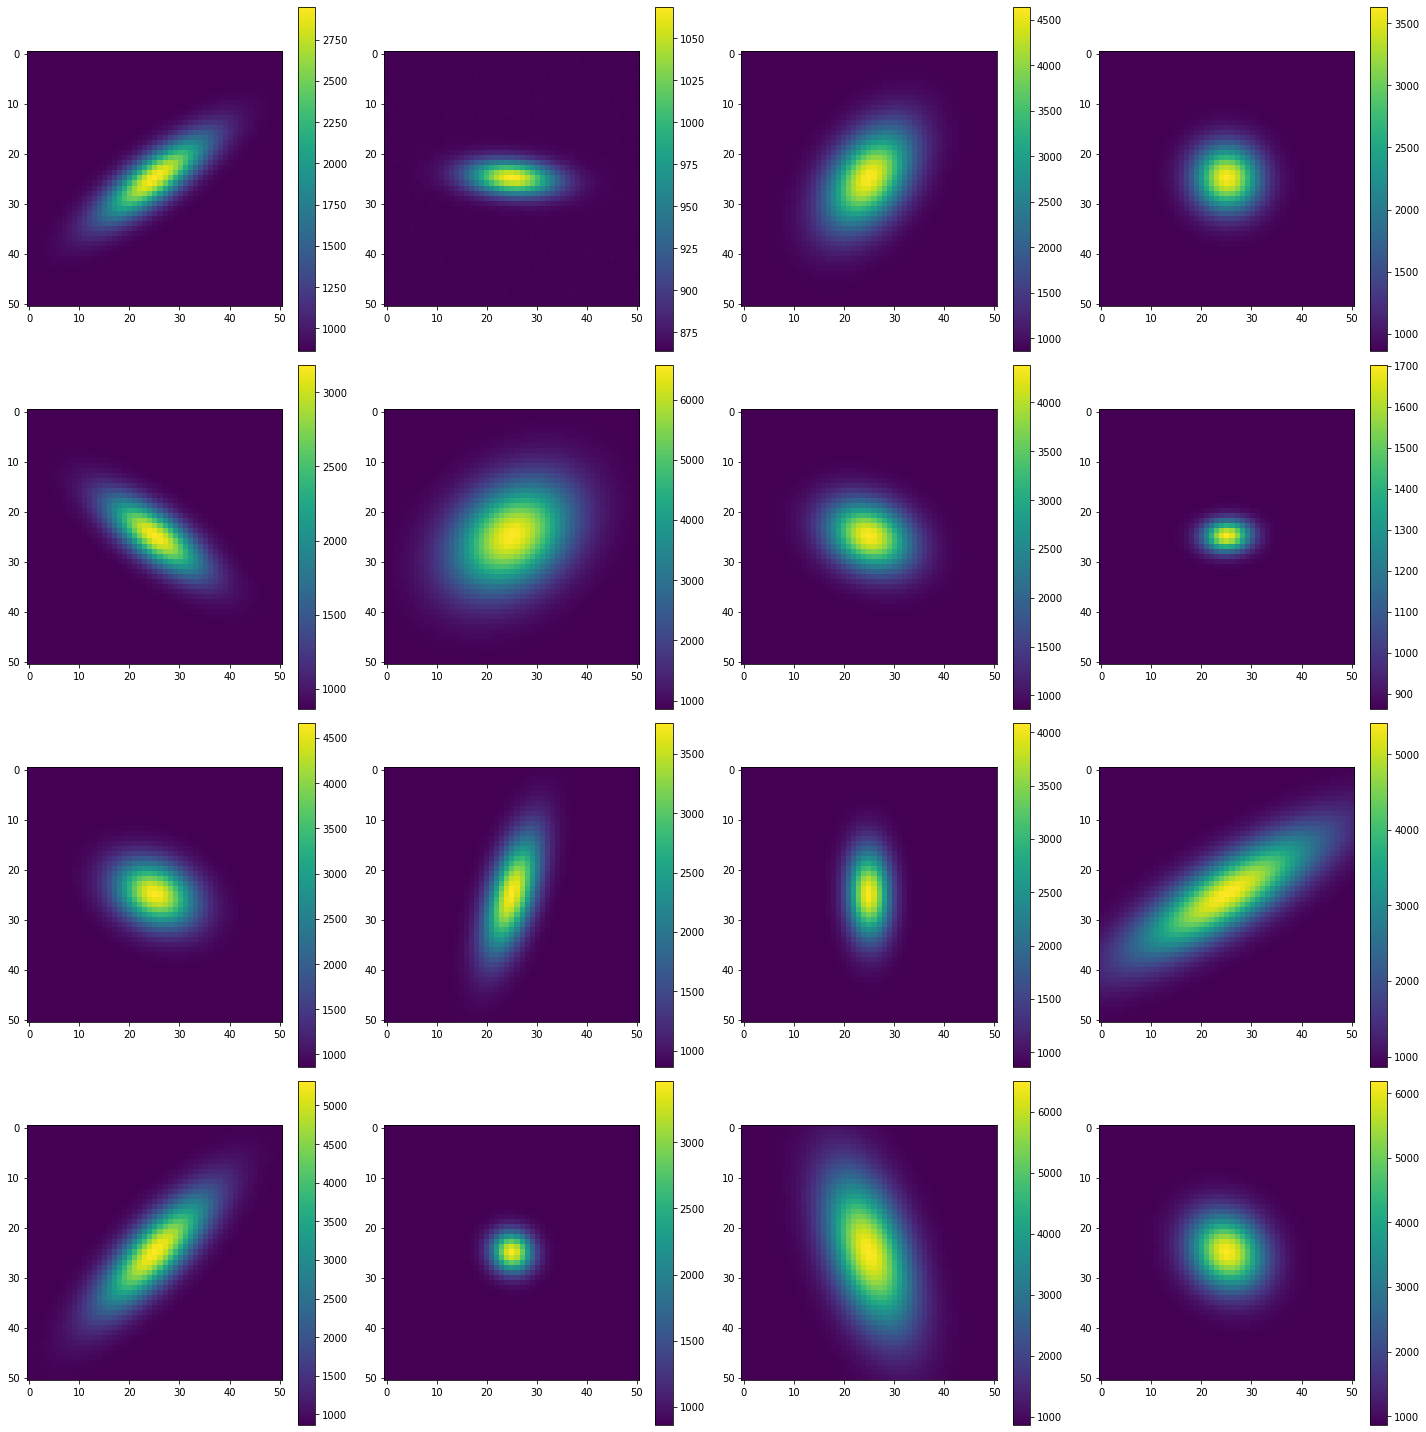

In [23]:
plot_example_galaxies(ds, n_samples=16)

## Create model and train

In [12]:
# what model are we using?
# NOTE: warm_up = 0 and beta = 1 means standard ELBO loss. 
print(cfg.model)

{'name': 'OneCenteredGalaxy', 'warm_up': 0, 'beta': 1, 'enc_dec_name': 'simple', 'loss_type': 'L2', 'params': {'slen': 51, 'latent_dim': 8, 'n_bands': 1, 'hidden': 256}}


In [13]:
VAE = bliss.models.galaxy_net.OneCenteredGalaxy(cfg)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name | Type          | Params
---------------------------------------
0 | enc  | SimpleEncoder | 10.9 M
1 | dec  | SimpleDecoder | 11.3 M
---------------------------------------
22.1 M    Trainable params
0         Non-trainable params
22.1 M    Total params
88.523    Total estimated model params size (MB)
/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

1

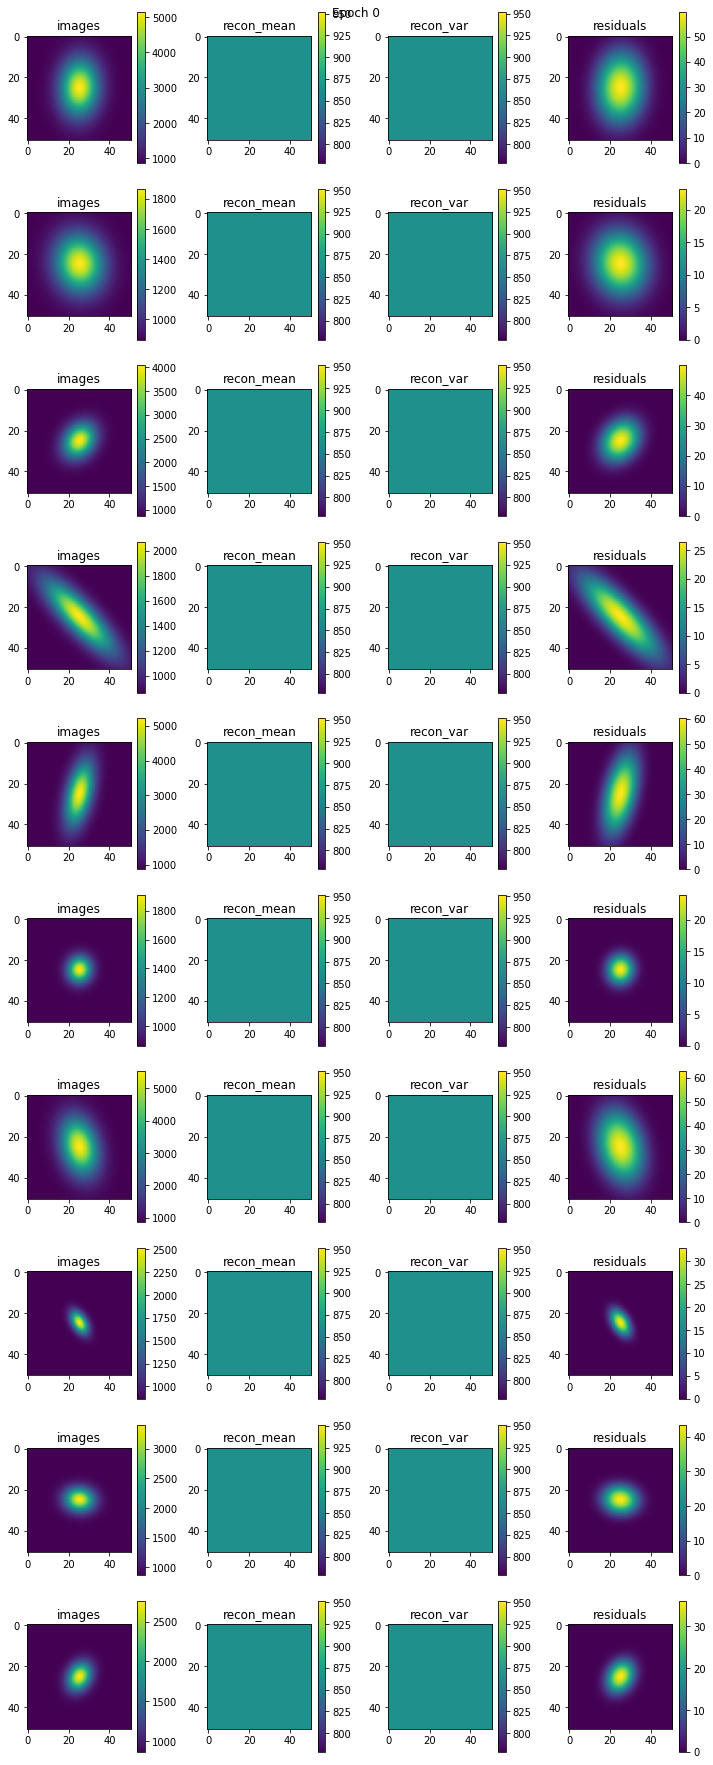

In [14]:
# create trainer
n_epochs = 101
trainer = pl.Trainer(profiler=None, logger=False, checkpoint_callback=False, 
                     max_epochs=n_epochs, min_epochs=n_epochs, 
                     gpus=[2], check_val_every_n_epoch=1001,)


# train! 
trainer.fit(VAE, datamodule=ds)

## How did we do? 

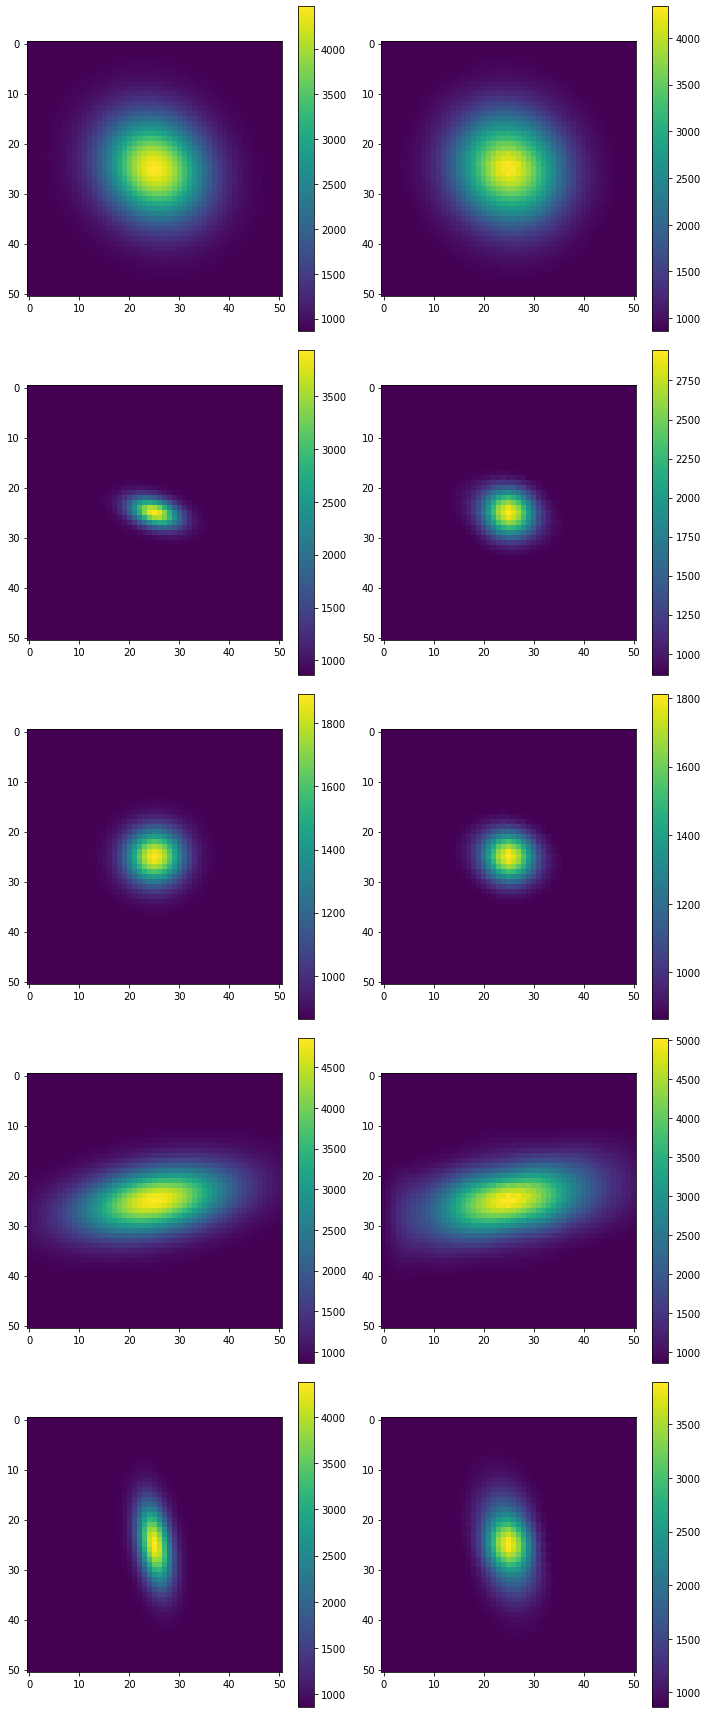

In [16]:
import torch
VAE.eval()

# example reconstruction
# some example centered individual galaxies from the dataset.
fig, axes = plt.subplots(5,2, figsize=(10, 24))

#always different.
for b in dataset.train_dataloader():
    batch = b
    break

recon_mean, recon_var, _ = VAE(batch['images'],batch['background'])

for i, (ax1, ax2) in enumerate(axes):
    
    # plot
    im1 = ax1.imshow(batch['images'][i][0])
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(recon_mean[i][0].detach().numpy())
    fig.colorbar(im2, ax=ax2)
plt.tight_layout()

# SDSS Galaxies

## Create dataset

First we create the dataset containing SDSS galaxies. These galaxies have realistic sizes and fluxes from a catalog, but the morphology is bulge+disk+agn (basically a parametric Sersic mixture) so they are not as realistic as they could be. 

In [24]:
# the catalog we will be using has a sample of 'easiest' (not too small or too faint) galaxies in the catalog.
catalog_file = '../../data/gold_dc2_catalog.fits'

In [25]:
overrides = {
             # dataset information
             'dataset':'sdss_galaxies',
             'dataset.params.slen': 51,
             'dataset.cosmoDC2_file': catalog_file,
    
             # model info. 
             'model':'galaxy_net',
             'model.loss_type': 'L2', # another option is 'L1' for l1-loss. 
             'model.enc_dec_name': 'simple', # this specifies which architecture to use for the encoder/decoder. 
                                            # default is 'simple', the original VAE we were using. 
                                            # Other options are 'bastien' and 'jeff'. See bliss/models/vae_layers.py for options.
             'model.params.slen': 51,
    
             # pytorch lightning trainer. 
             'training': 'default'
}
cfg = get_cfg(overrides)
ds = bliss.datasets.galsim_galaxies.SDSSGalaxies(cfg)

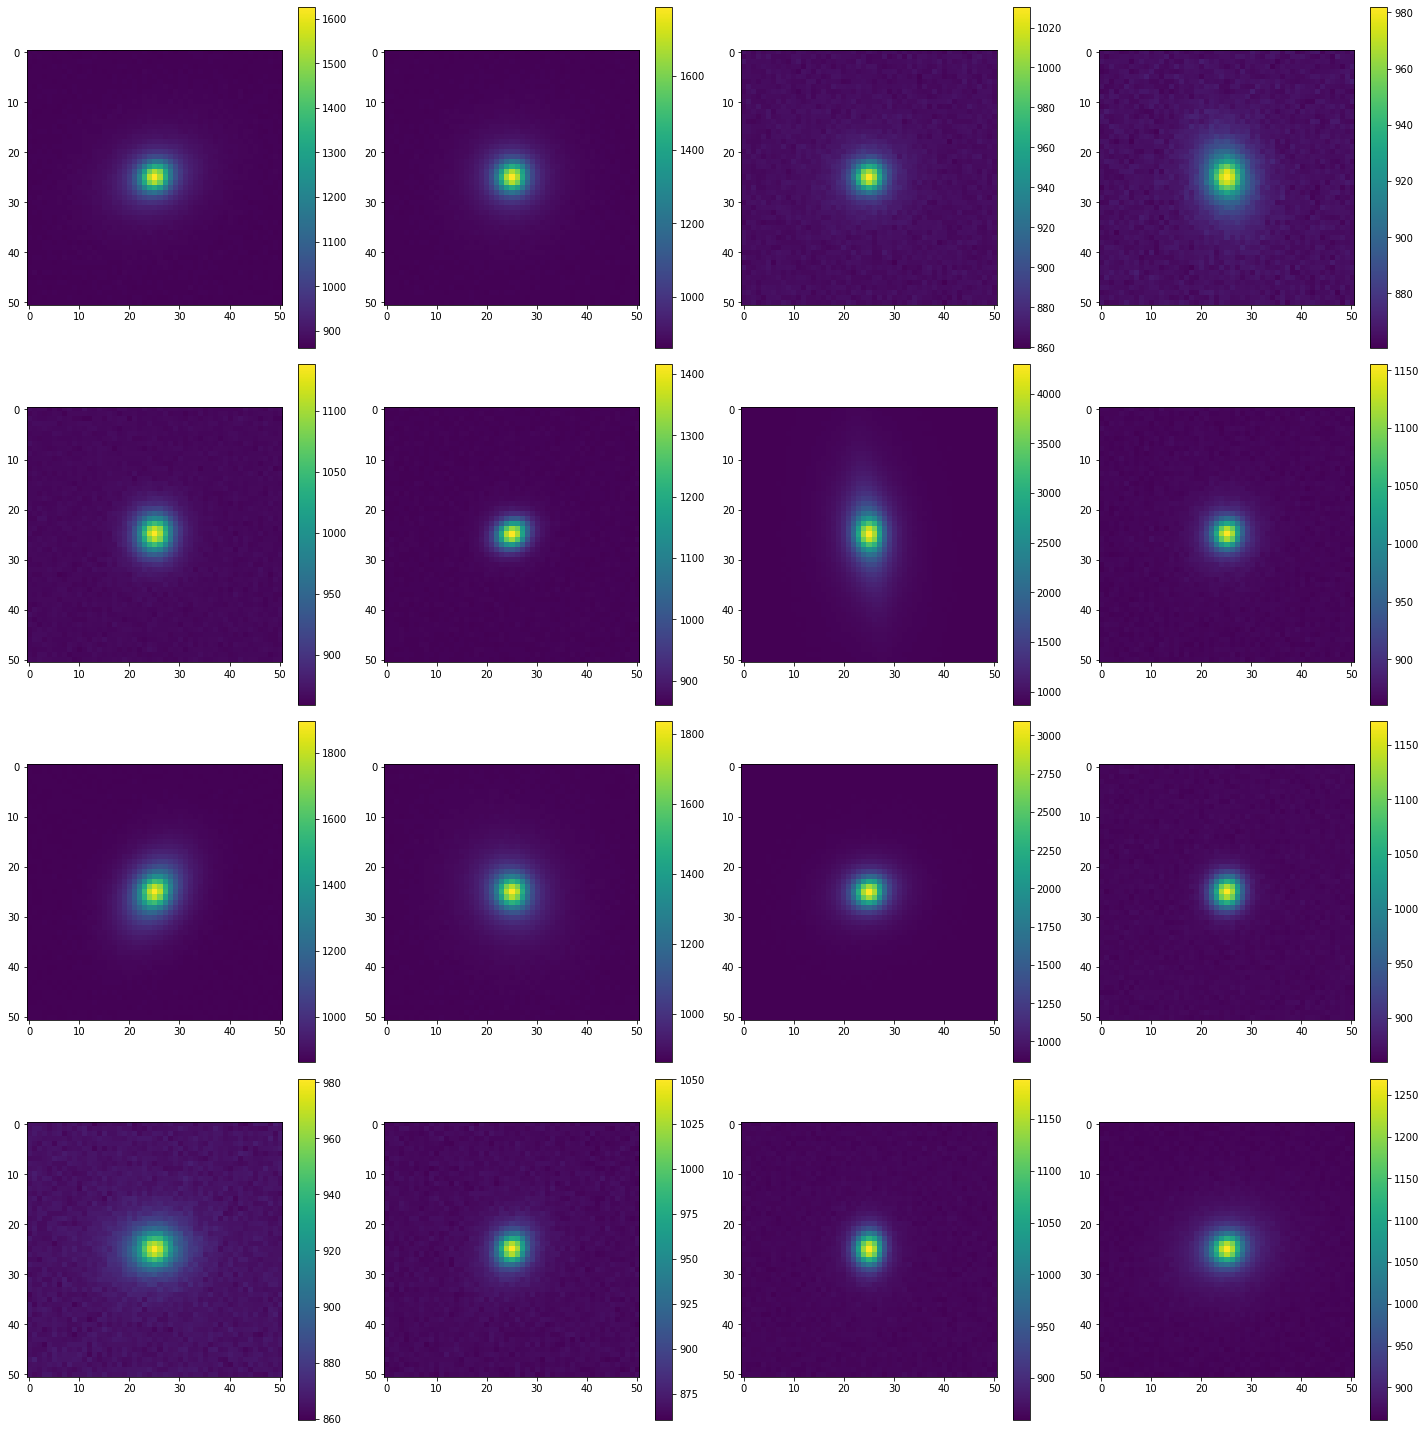

In [26]:
plot_example_galaxies(ds)

## Create VAE and Train

The configuration object we created above already contains the model information for our galaxy VAE. 

In [27]:
print(cfg.model)

{'name': 'OneCenteredGalaxy', 'warm_up': 0, 'beta': 1, 'enc_dec_name': 'simple', 'loss_type': 'L2', 'params': {'slen': 51, 'latent_dim': 8, 'n_bands': 1, 'hidden': 256}}


We can create the VAE directly from this configuration. 

In [28]:
VAE = bliss.models.galaxy_net.OneCenteredGalaxy(cfg)

And we also need a trainer to train. 

In [29]:
# create trainer
n_epochs = 101
trainer = pl.Trainer(profiler=None, logger=False, checkpoint_callback=False, 
                     max_epochs=n_epochs, min_epochs=n_epochs, 
                     gpus=[2], check_val_every_n_epoch=1001,)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores



  | Name | Type          | Params
---------------------------------------
0 | enc  | SimpleEncoder | 10.9 M
1 | dec  | SimpleDecoder | 11.3 M
---------------------------------------
22.1 M    Trainable params
0         Non-trainable params
22.1 M    Total params
88.523    Total estimated model params size (MB)
/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

1

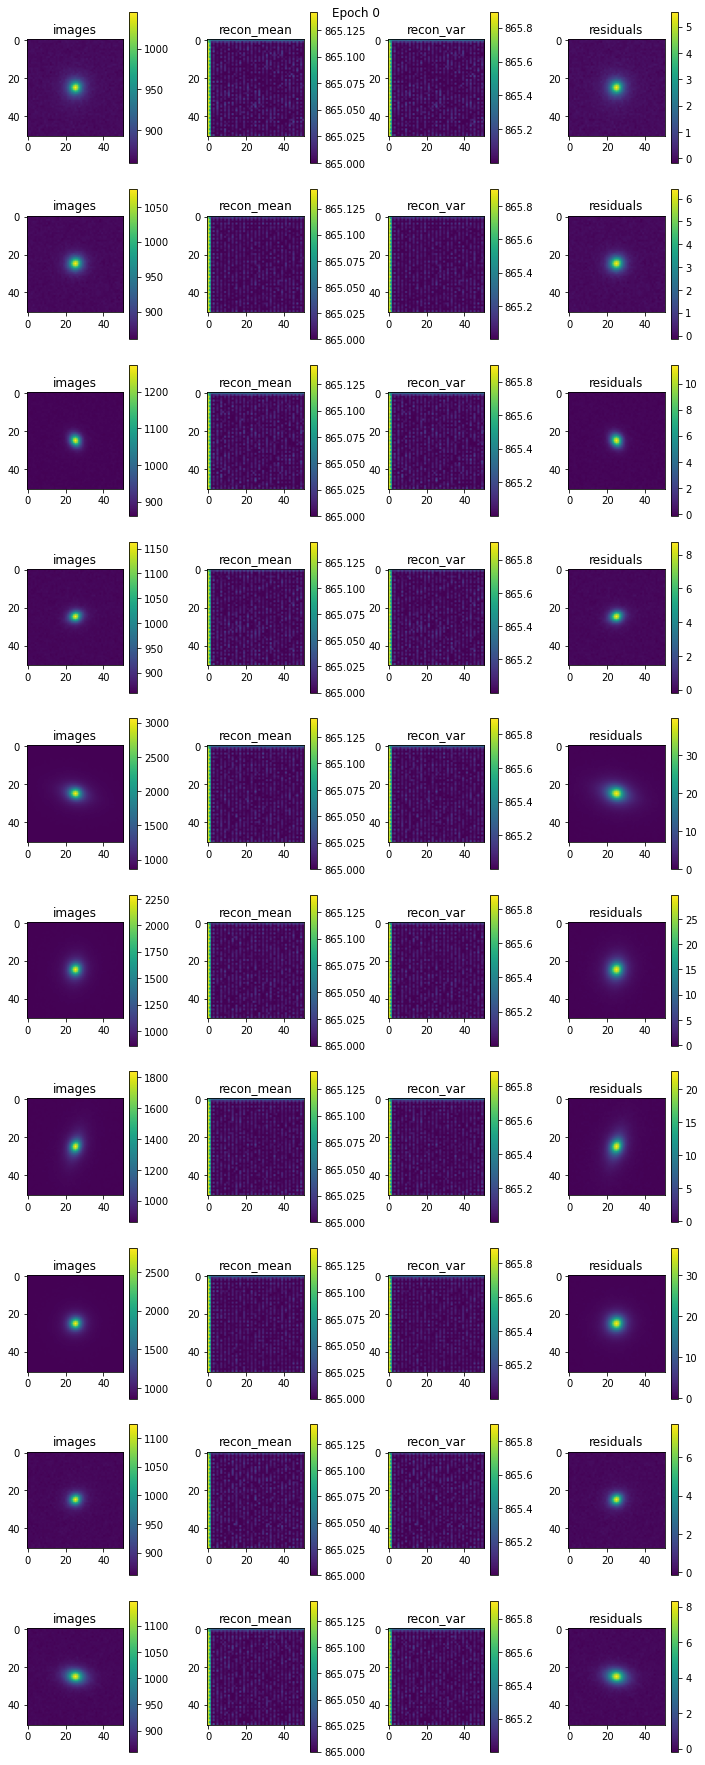

In [31]:
# train! 
trainer.fit(VAE, datamodule=ds)

## Compare results

Now that our model is trained we can compare some results. 

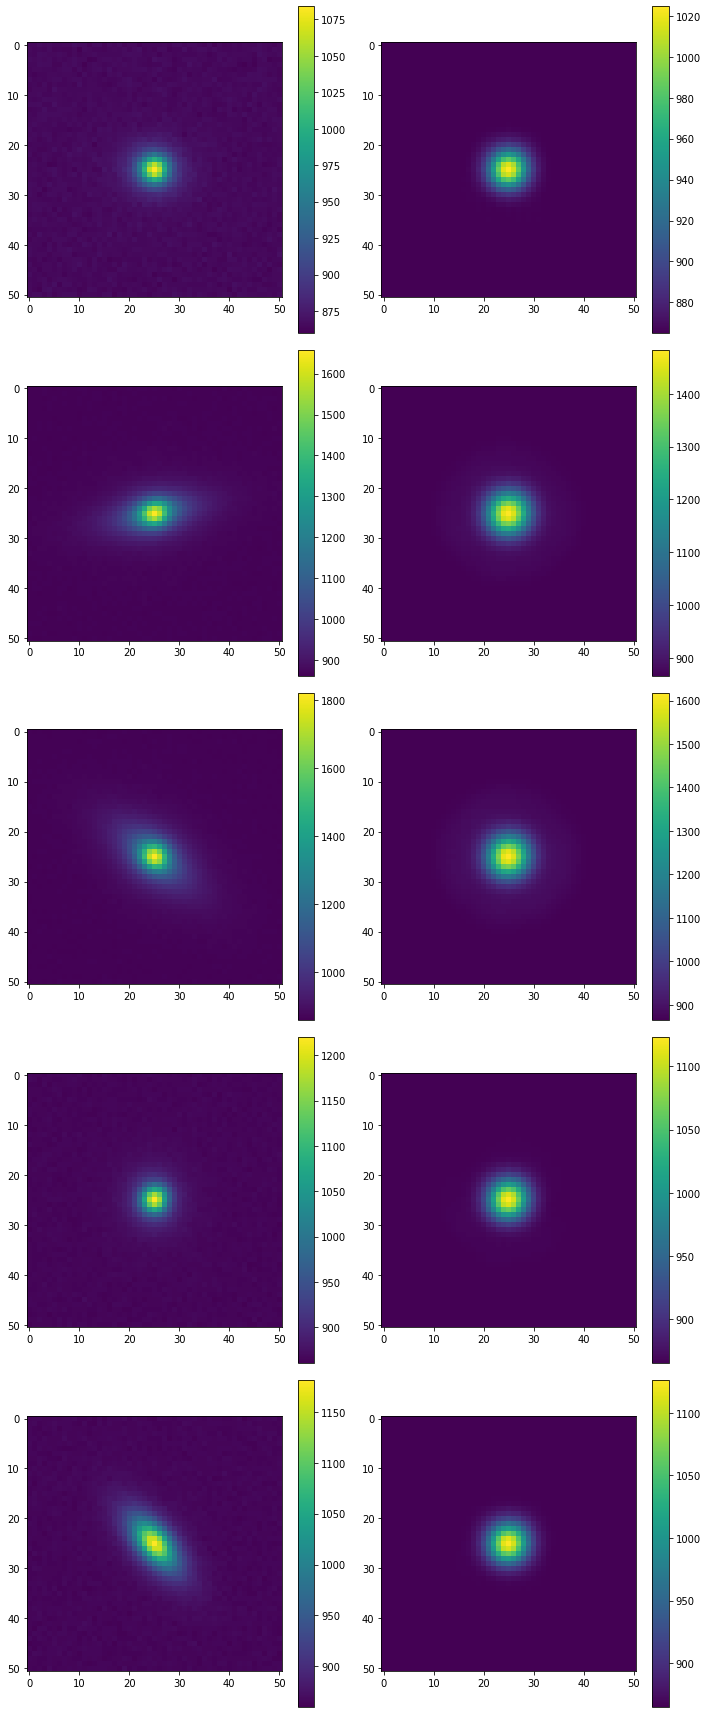

In [37]:
import torch
VAE.eval()

# example reconstruction
# some example centered individual galaxies from the dataset.
fig, axes = plt.subplots(5,2, figsize=(10, 24))

#always different.
for b in ds.train_dataloader():
    batch = b
    break

recon_mean, recon_var, _ = VAE(batch['images'],batch['background'])

for i, (ax1, ax2) in enumerate(axes):
    
    # plot
    im1 = ax1.imshow(batch['images'][i][0])
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(recon_mean[i][0].detach().numpy())
    fig.colorbar(im2, ax=ax2)
plt.tight_layout()